In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import scipy
from scipy import stats
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import cartopy.crs as ccrs
import glob
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
### load data of true, predicted, and observationally constrained feedbacks, see output of file ridge_train_on_obs_predict_cmip4xco2.ipynb
data = pd.read_csv('./data/results/SVW_feedback_results_60NS_allmodels_315samples_50_realisations_SWOOSH_finalNatGeo.csv',index_col='Unnamed: 0')

In [4]:
data

,feedbacks_true_am,feedbacks_pred_am,feedbacks_era5_0,feedbacks_merra_0,feedbacks_jra0,feedbacks_era5_1,feedbacks_merra_1,feedbacks_jra1,feedbacks_era5_2,feedbacks_merra_2,...,feedbacks_jra46,feedbacks_era5_47,feedbacks_merra_47,feedbacks_jra47,feedbacks_era5_48,feedbacks_merra_48,feedbacks_jra48,feedbacks_era5_49,feedbacks_merra_49,feedbacks_jra49
ACCESS1-0,0.773901,0.579223,0.230671,0.067362,0.317184,0.129907,0.020735,0.309755,0.138390,0.013624,...,0.314317,0.155930,0.030305,0.313902,0.137817,-0.070209,0.319911,0.211848,0.028605,0.334141
ACCESS1-3,0.339824,0.133675,0.307698,0.101427,0.447847,0.190157,0.061824,0.439360,0.204701,0.052563,...,0.445324,0.224755,0.072005,0.445834,0.200848,-0.044363,0.450745,0.291676,0.071336,0.482023
ACCESS-CM2,1.238250,1.271783,0.327180,0.074170,0.662258,0.218252,0.039763,0.644689,0.225204,0.028993,...,0.656269,0.246549,0.046791,0.653108,0.233219,-0.043431,0.666662,0.308405,0.048827,0.706973
ACCESS-ESM1-5,0.339732,0.351980,0.219482,0.027688,0.391720,0.131218,0.002446,0.382843,0.138014,-0.006918,...,0.389127,0.157966,0.012342,0.390141,0.142033,-0.058739,0.394610,0.207345,0.012061,0.415703
AWI-CM-1-1-MR,0.599236,0.449511,0.344808,0.140870,0.480766,0.224916,0.093073,0.469865,0.239364,0.081878,...,0.476198,0.254345,0.099719,0.474032,0.238072,-0.022298,0.483323,0.324655,0.099534,0.504953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NorESM1-M,0.292601,0.157784,0.234446,0.084177,0.297715,0.157798,0.053168,0.292830,0.163944,0.046214,...,0.293879,0.176397,0.059680,0.295145,0.163861,-0.029841,0.298273,0.220689,0.060522,0.310005
NorESM2-LM,0.239945,0.227531,0.254371,0.059173,0.449258,0.177427,0.040590,0.444349,0.166609,0.019231,...,0.446419,0.192325,0.040889,0.445190,0.178215,-0.046915,0.448398,0.248738,0.047089,0.469514
NorESM2-MM,0.338866,0.257713,0.221712,0.017056,0.411836,0.153827,0.000072,0.404556,0.135994,-0.022100,...,0.408009,0.167466,0.004222,0.408863,0.153830,-0.065211,0.407538,0.215186,0.011135,0.420989
SAM0-UNICON,0.439915,0.561578,0.260749,0.048956,0.424770,0.156194,0.005634,0.415825,0.159593,-0.005988,...,0.424103,0.187731,0.016646,0.425978,0.163656,-0.081578,0.426584,0.243574,0.013276,0.451883


In [5]:
model_list_selected = ['ACCESS1-0', 'ACCESS1-3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'CAMS-CSM1-0', 'CanESM5', 'CESM2_', 
               'CESM2-WACCM', 'FGOALS-f3-L', 'GFDL-CM3', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 
               'INM-CM5-0', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

In [6]:
len(model_list_selected)

27

In [7]:
### prepare containers, then calculate sigma(theta) and sigma (temperature), see Methods section in paper
nr_reanalyses = 3
nr_realizations = 50
reanalysis_theta_times_XmeanCMIPall = np.empty((nr_reanalyses*nr_realizations))
reanalysis_theta_times_XmeanCMIPselected = np.empty((nr_reanalyses*nr_realizations))
reanalysis_meantheta_times_XCMIPall = np.empty((61))
reanalysis_meantheta_times_XCMIPselected = np.empty((len(model_list_selected)))

In [8]:
reanalysis_theta_times_XmeanCMIPall = np.mean(data.iloc[:,2:].values,axis=0)
reanalysis_theta_times_XmeanCMIPselected = np.mean(data.loc[model_list_selected].iloc[:,2:].values,axis=0)

In [9]:
counter=0
for i in list(data.index):
    reanalysis_meantheta_times_XCMIPall[counter] = np.mean(data.loc[[i]].iloc[:,2:].values)
    counter = counter+1

In [10]:
counter=0
for i in model_list_selected:
    reanalysis_meantheta_times_XCMIPselected[counter] = np.mean(data.loc[[i]].iloc[:,2:].values)
    counter = counter+1

In [11]:
sigma_theta_all = np.std(reanalysis_theta_times_XmeanCMIPall)
sigma_theta_selected = np.std(reanalysis_theta_times_XmeanCMIPselected)
print(sigma_theta_all,sigma_theta_selected)
sigma_X_all = np.std(reanalysis_meantheta_times_XCMIPall)
sigma_X_selected = np.std(reanalysis_meantheta_times_XCMIPselected)
print(sigma_X_all,sigma_X_selected)

0.17344911623221337 0.18670884964277842
0.08667438117083916 0.05639163976610455


In [12]:
sigma_total_all = np.sqrt(sigma_theta_all**2+sigma_X_all**2)
sigma_total_selected = np.sqrt(sigma_theta_selected**2+sigma_X_selected**2)
print(sigma_total_all,sigma_total_selected)
mean_obs_all = np.mean(reanalysis_theta_times_XmeanCMIPall)
mean_obs_selected = np.mean(reanalysis_theta_times_XmeanCMIPselected)
print(mean_obs_all,mean_obs_selected)

0.1938995726480174 0.19503900012674322
0.23254617602740096 0.24799371856288568


In [13]:
all_true = np.empty((61))
all_pred = np.empty((61))
selected_true = np.empty(len(model_list_selected))
selected_pred = np.empty(len(model_list_selected))

In [14]:
### calculate prediction intervals according to Wilkes Statistical Methods in the Atmospheric Sciences (references in paper)
def sy(mse,x0,subset):
    x = data['feedbacks_pred_am'].loc[subset].values
    n = len(x)
    xm = np.mean(x)
    stderr = mse*(1+1/float(n)+(x0-xm)**2/np.sum((x-xm)**2))
    return np.sqrt(stderr)

In [15]:
### do the Monte Carlo sampling
### first create samples for the distribution of 'observed' feedbacks on the x-axis
N=1e7
x_samples_all = np.random.normal(mean_obs_all,sigma_total_all,int(N))
x_samples_selected = np.random.normal(mean_obs_selected,sigma_total_selected,int(N))

0.8523264588409079 0.09476509667253741 0.8952804514507955 2.910934658969425e-10
[-1.        -0.9991453 -0.9982906 ...  2.4982906  2.4991453  2.5      ]
(4096,)
(4096,) 0.9999998999997805
[4.46002010e-54 4.48335510e-54 4.48346247e-54 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[-0.16581197] cdf>0.025
[0.76837607] cdf<0.975
[-0.08888889] cdf>0.05
[0.69487179] cdf<0.95
[0.07606838] cdf>1/6
[0.53589744] cdf<5/6
[0.30769231] 50th percentile


Text(0.2, 0.8, 'r = 0.90')

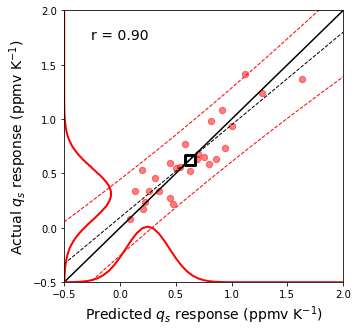

In [16]:
plt.rcParams['figure.figsize'] = [5, 5]
x_range = np.arange(-0.5,2.25,0.05)
slope, intercept, r_value, p_value, std_err = stats.linregress(data['feedbacks_pred_am'].loc[model_list_selected].values,data['feedbacks_true_am'].loc[model_list_selected].values)
print(slope, intercept, r_value, p_value)
### then use those samples to create 'uncertain' predictions on the y-axis
predictions = intercept+slope*x_samples_selected
mse = mean_squared_error(data['feedbacks_pred_am'].loc[model_list_selected].values,data['feedbacks_true_am'].loc[model_list_selected].values)
error_lim_size = sy(mse,x_samples_selected,model_list_selected)
y_samples_selected = np.random.normal(predictions,error_lim_size,int(1e7))
y_density = stats.gaussian_kde(y_samples_selected,bw_method=0.01)
y_range = np.linspace(-1.0,2.5,4096)
print(y_range)
y_density_predictions = y_density(y_range)
print(y_density_predictions.shape)
cdf = np.cumsum(y_density_predictions)*np.diff(y_range)[0:1]
print(cdf.shape,np.max(cdf))
cdf = cdf/np.max(cdf)
print(cdf)
### indices for 95% 
i95_left = np.argwhere(cdf>0.025)[0]
print(y_range[i95_left],'cdf>0.025')
i95_right = np.argwhere(cdf<0.975)[-1]
print(y_range[i95_right],'cdf<0.975')
### indices for 90%
i90_left = np.argwhere(cdf>0.05)[0]
print(y_range[i90_left],'cdf>0.05')
i90_right = np.argwhere(cdf<0.95)[-1]
print(y_range[i90_right],'cdf<0.95')
### indices for 66%
i66_left = np.argwhere(cdf>1/6)[0]
print(y_range[i66_left],'cdf>1/6')
i66_right = np.argwhere(cdf<5/6)[-1]
print(y_range[i66_right],'cdf<5/6')
i50 = np.argwhere(cdf>0.5)[0]
print(y_range[i50],'50th percentile')
plt.plot(x_range,x_range, color='k',linewidth=1.5,linestyle='-')
plt.scatter(data['feedbacks_pred_am'].loc[model_list_selected].values,data['feedbacks_true_am'].loc[model_list_selected].values,color='r',marker='o',s=40,alpha=0.5)
plt.scatter(np.mean(data['feedbacks_pred_am'].loc[model_list_selected].values),np.mean(data['feedbacks_true_am'].loc[model_list_selected].values),marker='s',s=90,color='white',edgecolors='k',linewidths=3)
plt.plot(x_range,intercept+slope*x_range,color='k',linestyle='--',linewidth=1)
prediction_interval = sy(mse,x_range,model_list_selected)
plt.plot(x_range,intercept+slope*x_range+prediction_interval*2,color='r',linestyle='--',linewidth=1)
plt.plot(x_range,intercept+slope*x_range-prediction_interval*2,color='r',linestyle='--',linewidth=1)
plt.plot(x_range,stats.norm.pdf(x_range,mean_obs_selected,sigma_total_selected)*0.25-0.5,color='r',linewidth=2)
plt.plot(y_density_predictions*0.25-0.5,y_range,color='r',linewidth=2)
plt.xlim(-0.5,2.0)
plt.ylim(-0.5,2.0)
plt.xlabel('Predicted $q_s$ response (ppmv K$^{-1}$)',size=14)
plt.ylabel('Actual $q_s$ response (ppmv K$^{-1}$)',size=14)
plt.figtext(0.2,0.8,'r = '+str("{:.2f}".format(round(r_value,2))),size=14)
plt.show()

In [20]:
### now plot 2 (b)
nr_models=61
model_list = ['ACCESS1-0', 'ACCESS1-3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'bcc-csm1-1_',
             'bcc-csm1-1-m','BCC-CSM2-MR_', 'BCC-ESM1', 'BNU-ESM', 'CAMS-CSM1-0', 'CanESM2', 'CanESM5',
             'CCSM4', 'CESM2_', 'CESM2-WACCM', 'CNRM-CM5', 'CNRM-CM6-1','CNRM-ESM2-1','CSIRO-Mk3-6-0', 'E3SM-1-0', 'EC-Earth3-Veg', 'EC-EARTH', 'FGOALS-f3-L', 'FGOALS-g2', 'FGOALS-g3', 
             'GFDL-CM3', 'GFDL-CM4', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GFDL-ESM4',
             'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'HadGEM3-GC31-LL',
             'HadGEM3-GC31-MM', 'inmcm4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'IPSL-CM6A-LR',
             'MIROC5', 'MIROC6', 'MIROC-ES2L', 'MIROC-ESM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-CGCM3',
             'MRI-ESM2-0', 'NESM3', 'NorESM1-M', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']
level_selected=1
slopes_all = np.empty((nr_models))
for modeli in range(0,nr_models):
    nt_4xco2 = 1800
    Y_raw_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/hus/hus*'+model_list[modeli]+'*4xCO2*.nc')[0])['hus'][:nt_4xco2,level_selected,0,0]*1e6/0.6213
    nt_4xco2 = Y_raw_4xco2.shape[0]
    tas_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/tas/tas_global_mean/tas*'+model_list[modeli]+'*4xCO2*.nc')[0])['tas'][:nt_4xco2,0,0]
    tas_4xco2_am = np.empty((int((tas_4xco2.shape[0]-12)/12)))#     X_lag_4xco2_norm_era5 = X_lag_4xco2_norm*np.sqrt(x_scaler_hist.var_)/np.sqrt(x_scaler_era5.var_)
    y_true_am = np.empty((int((nt_4xco2/12)-1)))
    for i in np.arange(12,nt_4xco2,12):
        y_true_am[int(i/12)-1] = np.mean(Y_raw_4xco2[i:i+12])
        tas_4xco2_am[int(i/12)-1] = np.mean(tas_4xco2[i:i+12],axis=0)
    res_mm_true_am = stats.linregress(tas_4xco2_am[:],y_true_am[:])
    slopes_all[modeli] = res_mm_true_am.slope

In [23]:
nr_models = len(model_list_selected)
slopes_clean = np.empty((nr_models))
for modeli in range(0,nr_models):
    nt_4xco2 = 1800
    Y_raw_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/hus/hus*'+model_list_selected[modeli]+'*4xCO2*.nc')[0])['hus'][:nt_4xco2,level_selected,0,0]*1e6/0.6213
    nt_4xco2 = Y_raw_4xco2.shape[0]
    tas_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/tas/tas_global_mean/tas*'+model_list_selected[modeli]+'*4xCO2*.nc')[0])['tas'][:nt_4xco2,0,0]
    tas_4xco2_am = np.empty((int((tas_4xco2.shape[0]-12)/12)))#     X_lag_4xco2_norm_era5 = X_lag_4xco2_norm*np.sqrt(x_scaler_hist.var_)/np.sqrt(x_scaler_era5.var_)
    y_true_am = np.empty((int((nt_4xco2/12)-1)))
    for i in np.arange(12,nt_4xco2,12):
        y_true_am[int(i/12)-1] = np.mean(Y_raw_4xco2[i:i+12])
        tas_4xco2_am[int(i/12)-1] = np.mean(tas_4xco2[i:i+12],axis=0)
    res_mm_true_am = stats.linregress(tas_4xco2_am[:],y_true_am[:])
    slopes_clean[modeli] = res_mm_true_am.slope

In [24]:
from matplotlib.patches import Rectangle

In [25]:
#### calculate means and medians for all sub-ensembles
cmip5_indices = [0,1,5,6,9,11,13,16,19,22,24,26,28,29,33,34,35,38,41,42,44,47,50,51,52,53,56]
cmip6_indices = [2,3,4,7,8,10,12,14,15,17,18,20,21,23,25,27,30,31,32,36,37,39,40,43,45,46,48,49,54,55,57,58,59,60]
print(np.mean(slopes_all[cmip5_indices]),np.median(slopes_all[cmip5_indices]))
print(np.mean(slopes_all[cmip6_indices]),np.median(slopes_all[cmip6_indices]))
print(np.mean(slopes_all),np.median(slopes_all))
print(np.mean(slopes_clean),np.median(slopes_clean))

0.6656592071831103 0.5325315881081129
0.5510550280899429 0.4946207366282415
0.601781468016427 0.5246064874454317
0.6280023609585359 0.5870198268767061


In [30]:
# [-0.16581197] cdf>0.025
# [0.76837607] cdf<0.975
# [-0.08888889] cdf>0.05
# [0.69487179] cdf<0.95
# [0.07606838] cdf>1/6
# [0.53589744] cdf<5/6
# [0.30769231] 50th percentile;

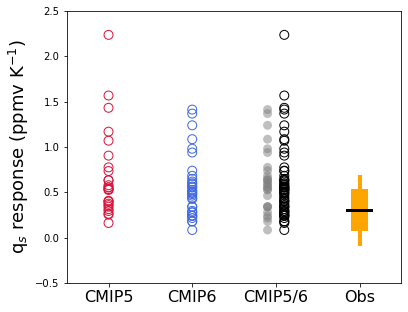

In [33]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.scatter(np.ones(len(model_list))*1.1,slopes_all,color='none',edgecolor='k',s=80)
plt.scatter(np.ones(len(model_list_selected))*0.9,slopes_clean,color='grey',edgecolor='none',s=80,alpha=0.5)
plt.scatter(np.ones(len(cmip6_indices))*0.0,slopes_all[cmip6_indices],color='none',edgecolor='royalblue',s=80)
plt.scatter(np.ones(len(cmip5_indices))*-1.0,slopes_all[cmip5_indices],color='none',edgecolor='crimson',s=80)
plt.gca().add_patch(Rectangle((1.9,0.07606838),0.2,0.53589744-0.07606838,facecolor='orange'))
plt.gca().add_patch(Rectangle((1.975,-0.08888889),0.05,0.69487179+0.08888889,facecolor='orange'))
plt.plot([1.85,2.1325],[0.30769231,0.30769231],linewidth=3,color='k')
plt.xticks([-1.0,0.0,1.0,2.0],labels=['CMIP5','CMIP6','CMIP5/6','Obs'],fontsize=16)
plt.xlim(-1.5,2.5)
plt.ylim(-0.5,2.5)
plt.ylabel('q$_s$ response (ppmv K$^{-1}$)',fontsize=18)
plt.show()